In [39]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from torchvision.models.detection import image_list
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from deep_sort_realtime.deepsort_tracker import DeepSort ##https://github.com/levan92/deep_sort_realtime The implementation given by the website also used API from https://github.com/nwojke/deep_sort, so I think it's legal
# Load Faster R-CNN with ResNet50 backbone, pretrained on COCO dataset
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the necessary transformation for input frames
transform = transforms.Compose([
    transforms.ToTensor(),
])

/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wzy/CS6613-zw4759/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def show_image(image, title="Image"):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_boxes(image, boxes, size0, size1,color=(0, 255, 0),  thickness=2):
    for i, box in enumerate(boxes):

        box = box.cpu().numpy()

        image = cv2.rectangle(image, (int(box[0]*size1[0][0]/size0[0][0]), int(box[1]*size1[0][1]/size0[0][1])), (int(box[2]*size1[0][0]/size0[0][0]), int(box[3]*size1[0][1]/size0[0][1])), color, thickness)
        
    return image

In [17]:
model.backbone #show the components:backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [18]:
model.rpn#RegionProposalNetwork

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [19]:
model.roi_heads #https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py 

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

In [20]:
class FasterRCNNVisualizer(torch.nn.Module):
    def __init__(self, model):
        super(FasterRCNNVisualizer, self).__init__()
        self.model = model

    def forward(self, images):
        # feature map from backbone(resnet)
        ##First perform some transform that is supposed to be done on the original model 
        image_mean = [0.485, 0.456, 0.406]
        image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(833, 1400, image_mean, image_std)
        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            torch._assert(
                len(val) == 2,
                f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
            )
            original_image_sizes.append((val[0], val[1]))
        images,tmp = transform(images,None)
        
        features = model.backbone(images.tensors) ##from https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py
        ##the backbone of rcnn generate the features
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])



        proposals, proposal_losses = model.rpn(images, features, None)
        #the regional proposals generated using features and images

        # final prediction using ROI Pooling
        detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, None)
        detections = transform.postprocess(detections, images.image_sizes, original_image_sizes)

        box_features = model.roi_heads.box_roi_pool(features, proposals, images.image_sizes) #we record the result after the Pooling process, this is included inside the roi_head module
        


        return features, proposals, detections,images.image_sizes,original_image_sizes,box_features


In [21]:
visualizer = FasterRCNNVisualizer(model)

tensor(37)


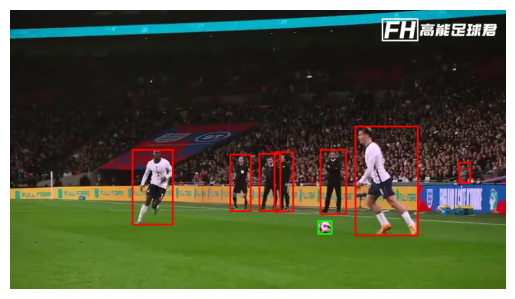

In [22]:
import pdb
#pdb.set_trace()
cap = cv2.VideoCapture('video.mp4')


frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
targetframe = 80




current_frame_idx = 0
raw_frame = None #Save it for visualization later
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    current_frame_idx += 1
    

    if current_frame_idx == targetframe:
        #
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        raw_frame = frame_rgb
        pil_img = Image.fromarray(frame_rgb)
        input_tensor = transform(pil_img).unsqueeze(0)
        
    
        with torch.no_grad():
            images = image_list.ImageList([input_tensor], [(pil_img.size[1], pil_img.size[0])])
            features, proposals,prediction,size0,size1,box_features=visualizer(input_tensor)
            
            labels = prediction[0]['labels']
            boxes = prediction[0]['boxes']
            scores = prediction[0]['scores']   


        for i in range(len(labels)):
            if scores[i] > 0.7:  # Only consider objects with a high confidence score
                if labels[i] == 1:  # Person label (in COCO)
                    color = (255, 0, 0)  # red for person
                else:  # I show all other labels here 
                    color = (0, 255, 0)  
                    print(labels[i])
                box = boxes[i].cpu().numpy()
                cv2.rectangle(frame_rgb, (int(box[0]*size1[0][0]/size0[0][0]), int(box[1]*size1[0][1]/size0[0][1])), (int(box[2]*size1[0][0]/size0[0][0]), int(box[3]*size1[0][1]/size0[0][1])), color, 2) # maually do some rescaling here

    # Show the frame with detections
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

        break  

cap.release()



In [23]:
print(features)
print(features['0'].shape)

OrderedDict([('0', tensor([[[[ 1.3389,  1.7353,  1.8819,  ...,  2.6173,  2.1791,  1.1725],
          [ 1.1955,  1.6064,  1.9285,  ...,  2.3595,  1.7341,  0.9749],
          [ 1.3285,  1.6574,  1.9477,  ...,  2.2401,  1.7105,  1.0536],
          ...,
          [ 1.3311,  1.9244,  2.3744,  ...,  1.3512,  1.1073,  0.4601],
          [ 1.6019,  2.3682,  2.7691,  ...,  1.8654,  1.7692,  0.8224],
          [ 0.6471,  1.1047,  1.4291,  ...,  0.9360,  0.8942,  0.2229]],

         [[ 0.4360, -0.7078, -0.8761,  ..., -0.5058, -0.5055, -1.0568],
          [ 0.6551, -1.0700, -1.4151,  ..., -0.4709, -0.5400, -1.6887],
          [ 0.4016, -1.2108, -1.5806,  ..., -0.2419, -0.4271, -1.6402],
          ...,
          [ 0.5600, -1.2001, -1.6271,  ..., -0.7889, -0.7369, -1.2877],
          [ 0.3458, -1.3559, -1.7442,  ..., -1.2236, -1.2008, -1.3008],
          [-0.0063, -1.2599, -1.5043,  ..., -1.3542, -1.3178, -1.0642]],

         [[-1.2110, -1.3115, -1.3503,  ..., -1.6709, -1.4031, -0.9753],
          [

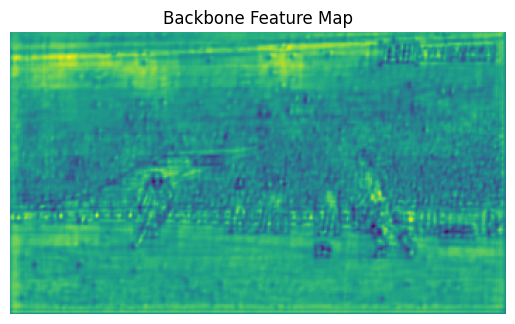

In [24]:
show_image(features['0'][0, 0].cpu().numpy(), title="Backbone Feature Map")

In [25]:
print(proposals)


[tensor([[ 866.4459,  594.9533,  910.5616,  636.0004],
        [ 348.2889,  389.8893,  460.6587,  608.9822],
        [ 971.4487,  333.9613, 1146.6877,  635.9216],
        ...,
        [ 756.1543,  461.7939,  793.3992,  560.5783],
        [ 900.4082,  461.1635, 1023.5244,  569.5405],
        [ 201.9377,  451.4719,  244.4925,  497.9009]])]


In [26]:
draw_boxes(raw_frame,proposals[0],size0,size1)#zero being the index of picture here, we only input a single picture

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[ 78, 116,  29],
        [ 78, 116,  29],
        [ 78, 116,  29],
        ...,
        [ 70, 106,  19],
        [ 70, 106,  19],
        [ 70, 106,  19]],

       [[ 78, 116,  29],
        [ 78, 116,  29],
        [ 78, 116,  29],
        ...,
        [ 70, 106,  19],
        [ 70, 106,  19],
        [ 70, 106,  19]],

       [[ 78, 116,  29],
        [ 78, 116,  29],
        [ 78, 116,  29],
        ...,
        [ 70, 106,  19],
        [ 70, 106,  19],
        [ 70, 106,  19]]

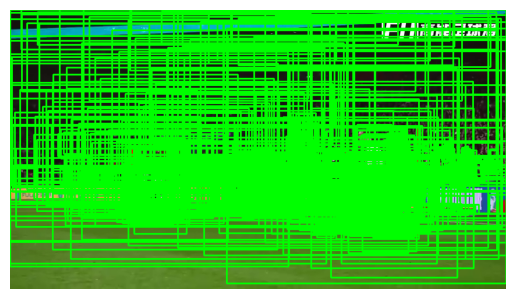

In [27]:
plt.imshow(raw_frame)##regional proposals
plt.axis('off')
plt.show()

In [28]:
print(box_features.shape) ##intermediate state after ROI pooling of proposals
box_features

torch.Size([1000, 256, 7, 7])


tensor([[[[ 6.4158e-01,  6.3145e-01,  3.2591e-01,  ...,  7.9829e-01,
            1.1977e+00,  1.6830e+00],
          [-9.1197e-02, -4.9829e-02, -6.5103e-01,  ...,  4.5022e-01,
            4.6475e-01,  9.2992e-01],
          [-2.6322e-01, -8.4531e-02, -1.0799e+00,  ..., -4.5239e-01,
           -5.5836e-01,  5.6392e-02],
          ...,
          [ 1.5919e-01,  7.1048e-01,  1.1154e-01,  ...,  9.5075e-01,
           -3.2871e-01, -1.8711e-01],
          [-1.6680e-01,  3.3556e-01, -2.4326e-01,  ...,  8.0019e-01,
            5.3950e-02,  5.4481e-01],
          [-5.2278e-01, -1.5869e-01, -3.7443e-01,  ..., -1.2232e-01,
           -4.4763e-01,  4.8003e-01]],

         [[ 5.5770e-01,  1.0374e+00,  9.5123e-01,  ...,  5.6723e-01,
            7.9789e-01,  8.2447e-01],
          [ 5.1826e-01,  8.2514e-01,  9.2072e-01,  ...,  3.7040e-01,
            9.8568e-01,  1.2428e+00],
          [ 3.1347e-01,  7.0636e-01,  1.5373e+00,  ...,  1.0886e+00,
            1.1256e+00,  1.3167e+00],
          ...,
     

In [29]:
print(box_features[0][0])

tensor([[ 0.6416,  0.6315,  0.3259,  0.5836,  0.7983,  1.1977,  1.6830],
        [-0.0912, -0.0498, -0.6510, -0.2563,  0.4502,  0.4647,  0.9299],
        [-0.2632, -0.0845, -1.0799, -1.2460, -0.4524, -0.5584,  0.0564],
        [-0.1469,  0.1806, -0.8869, -0.9799, -0.5556, -1.1959, -0.7003],
        [ 0.1592,  0.7105,  0.1115,  0.7539,  0.9507, -0.3287, -0.1871],
        [-0.1668,  0.3356, -0.2433,  0.4660,  0.8002,  0.0539,  0.5448],
        [-0.5228, -0.1587, -0.3744, -0.0083, -0.1223, -0.4476,  0.4800]])


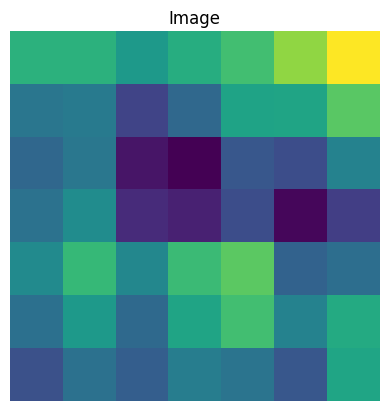

In [30]:
show_image(box_features[0][0]) ## a channel from one of the 1000 256*7*7 post-ROIpooling features, perhaps contain little information but anyway I visualize it

=====================task2========================

Structure:https://excalidraw.com/#json=knZkwTaYdA0yX3HxOoBUm,QrmXGnvATCCBJ_s501PHnw

Given an object tracker that is able to track objects in a single picture or a video. What the deep sort system has to do is to tell the relation ship between detected objects of different frames. And we can associate detections (e.g., from a target detector like Faster R-CNN) with existing tracks (e.g., previously identified objects). To get the matching, we use hungarian algorithm which perform a BFS search  to minimize the sum of distance instead of brutally search(which is Exponential complexity).More specifically, for each frame, compute a cost for each possible pairing between existing tracks and new detections. And the Hungarian Algorithm is used to solve this assignment problem by finding the optimal match that minimizes the total cost (i.e., maximizing the likelihood of correct matching). This ensures that each detected object is assigned to a tracked object (or a new track if no good match is found), and each track is updated accordingly. Once the best matches are found, the existing tracks are updated with the new detections, and new tracks are initialized for unmatched detections.

The Kalman filter is used to calculate the cost matrix mentioned above by predicting the motion of objects. 

State Prediction: $\hat{x}^{k} = F \hat{x}^{k-1} + B u_k$

Where $\hat{x}^{k}$ is the predicted state at time (k). F is the state transition matrix, which describes how the state evolves from time (k-1) to (k). $\hat{x}^{k-1}$ is the state estimate from the previous time step.B is the control input matrix, and $u_k$ is the control input (if any).

At time k an observation (or measurement) Z_k is made according to $z_k =H_k \hat{x}^{k-1} +u_k$ where $H_k$is the observation model, which maps the true state space into the observed space  

Predict covariance: $P_k = F P_{k-1} F^T + Q_k$  where P is the predicted error covariance matrix, representing uncertainty about the predicted state and Q is the process noise covariance matrix, representing the uncertainty in the process model.

During Update stage, the filter calculate measurement pre-fit residual$y_k$ and pre-fit covariance$S_k$ ,use them to calculate Kalman gain and corrects the prediction:$K_k = P_{k} H_k^T S^{-1}$.

With Kalman gain $K_k$, the filter updates the prediction $\hat{x}^{k} = \hat{x}^{k} + K_ky_k$ , $P_k = (I-K_kH_k)P_k$

The Prediction step predicts the state based on the previous estimate and control inputs.The Update step adjusts the predicted state based on the new measurement and calculates the Kalman Gain to balance the prediction and the measurement. Covariance matrices are used to track uncertainty in both the predicted state and measurement process.



In [40]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from torchvision.models.detection import image_list
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from deep_sort_realtime.deepsort_tracker import DeepSort




fasterrcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
fasterrcnn_model.eval()


transform = transforms.Compose([
    transforms.ToTensor(),
])

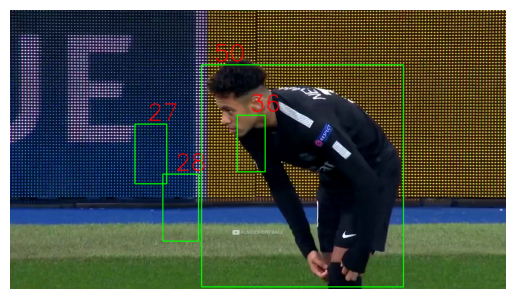

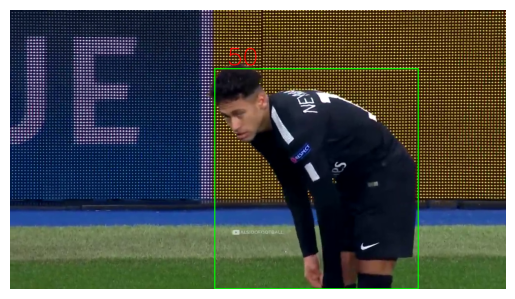

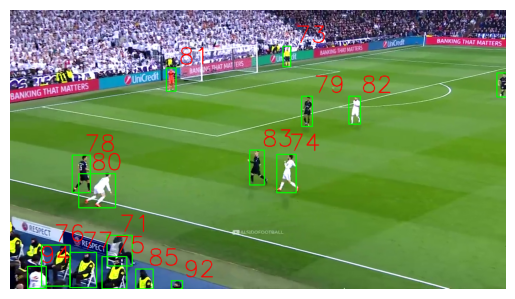

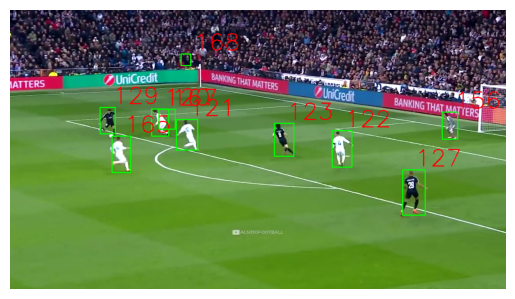

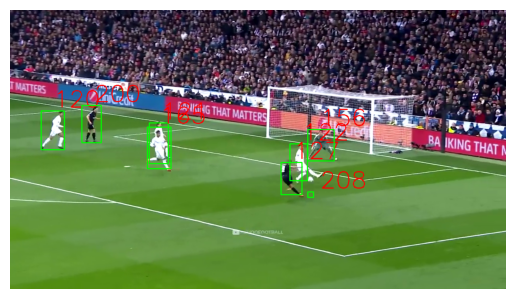

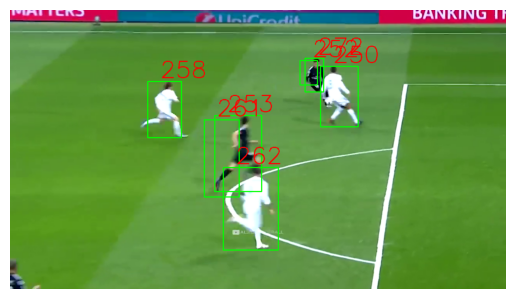

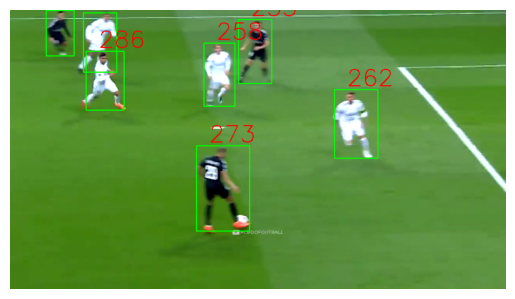

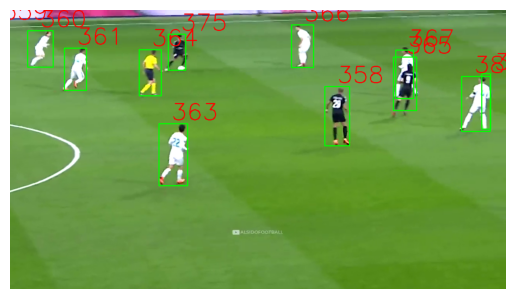

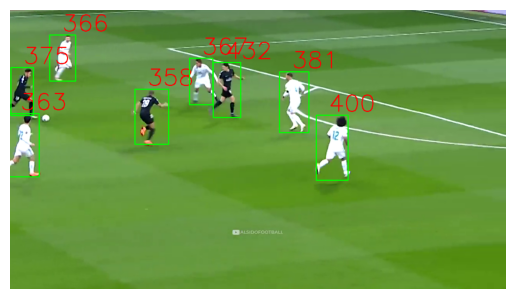

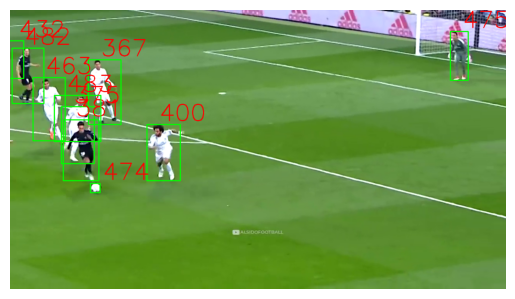

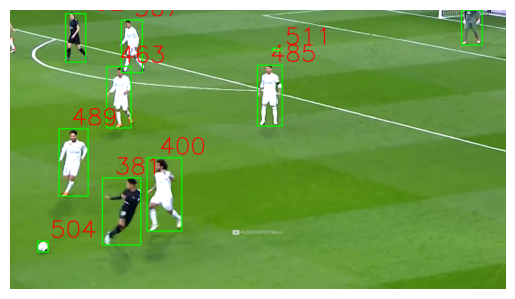

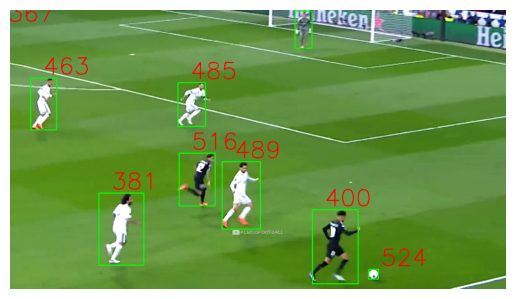

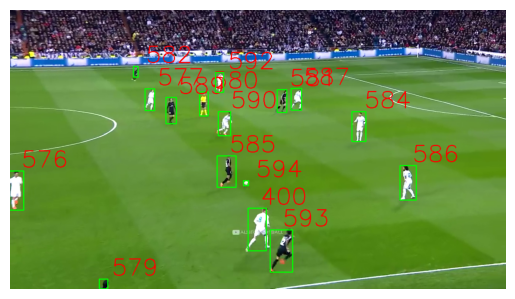

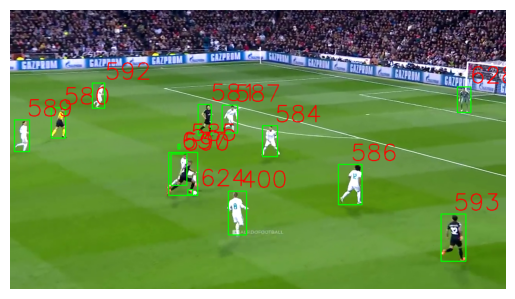

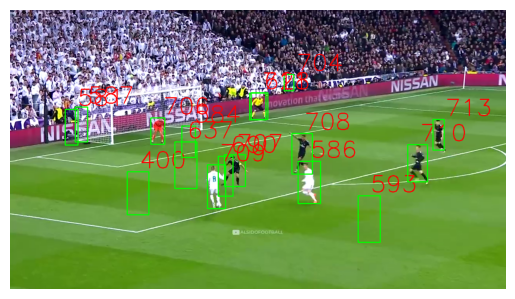

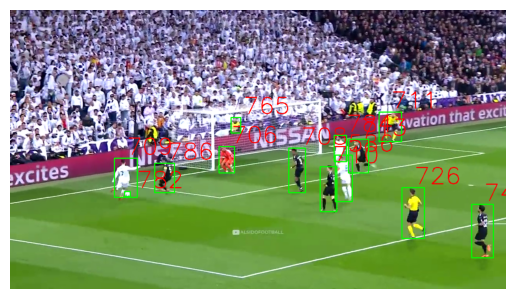

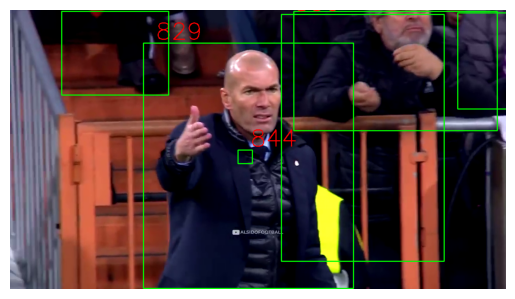

In [ ]:
cap = cv2.VideoCapture("video_youtube_original.mp4")
deepsort = DeepSort(max_age=10,max_iou_distance=0.55,max_cosine_distance=0.2)
# frame data
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
count = 0

out = cv2.VideoWriter("output_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image_rgb)

    input_tensor = transform(pil_img).unsqueeze(0)
    bbs=[]

    with torch.no_grad():
        prediction = fasterrcnn_model(input_tensor)

    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    for i in range(len(boxes)):
        if scores[i] > 0.8:
            #print(int(boxes[i][0]),int(boxes[i][1]),int(boxes[i][2]),int(boxes[i][3]))
            box_api = [int(boxes[i][0]),int(boxes[i][1]),int(boxes[i][2]-boxes[i][0]),int(boxes[i][3]-boxes[i][1])]
            bbs.append((box_api,scores[i],labels[i]))
            ##cv2.rectangle(image_rgb, (int(boxes[i][0]), int(boxes[i][1])), (int(boxes[i][2]), int(boxes[i][3])), (255, 0, 0), 2)
    deepsort.update_tracks
    tracks = deepsort.update_tracks(bbs, frame=image_rgb)
    
    tracksplot = 0

    for track in tracks:
        
        if not track.is_confirmed(): ##skip the tracks that are saved(no match founded)
            continue
        bbox = track.to_ltrb()  # get boundingbox
        track_id = track.track_id
        # plot boundingbox and ids
        cv2.rectangle(image_rgb, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        cv2.putText(image_rgb, f" {track_id}", (int(bbox[0]), int(bbox[1]-10) ), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
        tracksplot = tracksplot+1

    # show and save
    out.write(cv2.cvtColor(image_rgb,cv2.COLOR_RGB2BGR))
    count = count+1
    if count % 60 == 0:
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
out.release()
cv2.destroyAllWindows()